# Entraînement des modèles de clustering

## Objectifs du notebook :
- **Clustering avec K-Means** : Déterminer k optimal et entraîner le modèle
- **Réduction de dimensionnalité** : Appliquer l'ACP pour la visualisation  
- **Analyse des clusters** : Interpréter les groupes et définir les catégories de risque



# 2. Chargement des données

- Import des données standardisées issues du notebook de prétraitement 


In [55]:
import pandas as pd
df_cluster= pd.read_csv('../data/df_cluster.csv')
df_cluster=pd.DataFrame(df_cluster)
df_cluster_scaled = pd.read_csv('../data/df_cluster_scaled.csv')
df_cluster_scaled=pd.DataFrame(df_cluster_scaled)

 
- Vérification rapide de la forme et des colonnes



In [56]:
print("\n \n📊 Aperçu des données pour le clustering :\n")
print("Données filtrées (df_cluster) :")
print(df_cluster.head())
print("\nDonnées standardisées (df_cluster_scaled) :")
df_cluster_scaled


 
📊 Aperçu des données pour le clustering :

Données filtrées (df_cluster) :
   Glucose   BMI  Age  DiabetesPedigreeFunction
0      148  33.6   50                     0.627
1       85  26.6   31                     0.351
2      183  23.3   32                     0.672
3       89  28.1   21                     0.167
4      116  25.6   30                     0.201

Données standardisées (df_cluster_scaled) :


,Glucose,BMI,Age,DiabetesPedigreeFunction
0,0.889598,0.217690,1.531330,0.785203
1,-1.205391,-0.862381,-0.172664,-0.315398
2,2.053480,-1.371557,-0.082980,0.964648
3,-1.072376,-0.630937,-1.069502,-1.049132
4,-0.174524,-1.016677,-0.262347,-0.913551
...,...,...,...,...
704,-0.673331,0.109683,2.697220,-1.033181
705,0.024999,0.711436,-0.531399,-0.359263
706,-0.008255,-0.924099,-0.262347,-0.738093
707,0.158014,-0.322346,1.262278,-0.323374


# 3. Clustering avec K-Means

## 3.1 Déterminer la valeur optimale de k via la méthode du coude

Visualisation de la courbe d'inertie pour appuyer le choix de k.

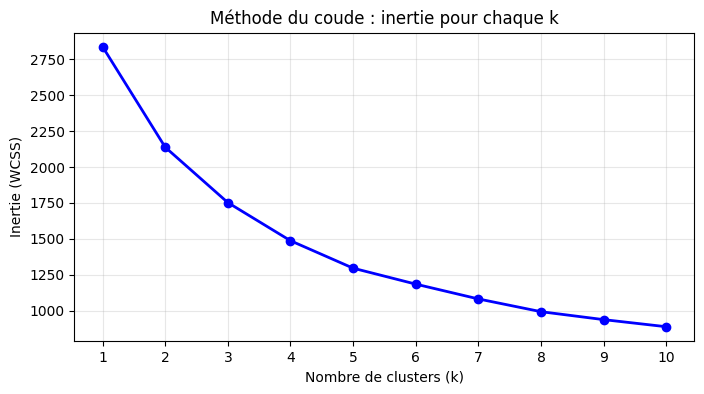

In [57]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calcul des inerties pour k de 1 à 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation avec annotation de chaque point
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=6)

plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (WCSS)')
plt.title('Méthode du coude : inertie pour chaque k')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()


In [58]:
from kneed import KneeLocator
# Détection automatique du coude
kl = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
k_optimal = kl.elbow
k_optimal=2
print(f"🎯 k optimal selon KneeLocator : {k_optimal}")


🎯 k optimal selon KneeLocator : 2


## 3.2 Entraîner un modèle K-Means avec le nombre de clusters choisi


- Entraînement du modèle avec ce k  


In [59]:
# Entraînement du modèle K-Means avec k optimal
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)

print(f"✅ Modèle K-Means entraîné avec k={k_optimal}")
print(f"📊 Inertie du modèle final: {kmeans.inertia_:.2f}")

✅ Modèle K-Means entraîné avec k=2
📊 Inertie du modèle final: 2137.12


## 3.3 Ajouter une colonne Cluster au dataset

In [60]:
df_cluster['cluster'] = cluster_labels

## 3.4 Visualiser la répartition des observations par cluster et interpréter les résultats

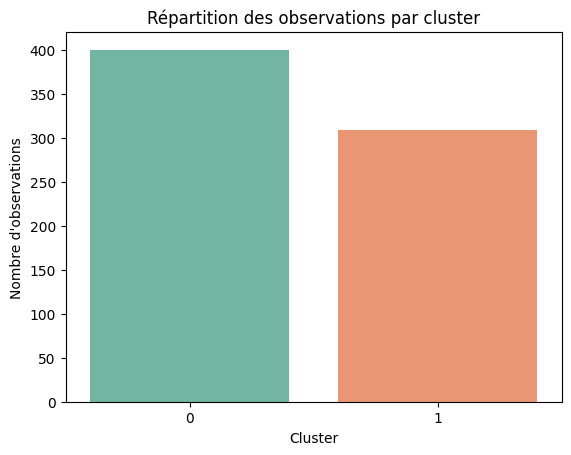

In [61]:
import seaborn as sns
sns.countplot(x='cluster', hue='cluster', data=df_cluster, palette='Set2', legend=False)
plt.title('Répartition des observations par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'observations')
plt.show()


# 4. Réduction de dimensionnalité pour visualisation

## 4.1 Appliquer l'ACP (PCA) pour réduire les dimensions à 2 axes

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_cluster_scaled)
df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

## 4.2 Réentraîner le modèle K-Means sur les nouvelles dimensions

In [63]:
# Réentraîner K-Means sur les composantes principales
kmeans_pca = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels_pca = kmeans_pca.fit_predict(df_pca)
df_pca['cluster'] = cluster_labels_pca

print(f"📊 Variance expliquée par les composantes principales:")
print(f"• PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"• PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"• Total: {pca.explained_variance_ratio_.sum():.1%}")
print(f"✅ K-Means réentraîné sur les dimensions PCA")

📊 Variance expliquée par les composantes principales:
• PC1: 36.1%
• PC2: 25.4%
• Total: 61.6%
✅ K-Means réentraîné sur les dimensions PCA


## 4.3 Visualiser les clusters obtenus et analyser la distribution

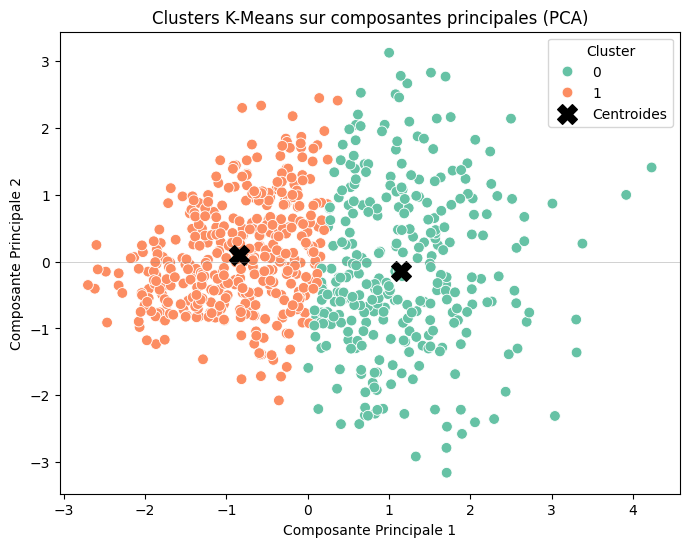

In [64]:
plt.figure(figsize=(8,6))

# Scatter plot of points colored by cluster
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60)

# Calculate and plot centroids
centroids = df_pca.groupby('cluster')[['PC1', 'PC2']].mean().reset_index()
plt.scatter(centroids['PC1'], centroids['PC2'], s=200, c='black', marker='X', label='Centroides')

# Thin, light x-axis line
plt.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)

plt.title('Clusters K-Means sur composantes principales (PCA)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Cluster')
plt.show()


---

# 5. Analyse des clusters

## 5.1 Calculer les moyennes des caractéristiques au sein de chaque cluster

In [65]:
# Calculer les moyennes des caractéristiques par cluster
numeric_columns = ['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
moyennes_par_cluster = df_cluster.groupby('cluster')[numeric_columns].mean()

print("📊 Moyennes des caractéristiques par cluster :")
print(moyennes_par_cluster.round(2))

📊 Moyennes des caractéristiques par cluster :
         Glucose    BMI  DiabetesPedigreeFunction    Age
cluster                                                 
0         104.93  29.78                      0.37  27.06
1         142.37  35.31                      0.50  40.52


## 5.2 Identification des clusters à haut risque selon les seuils critiques

Le cluster dont les moyennes des variables Glucose (>126), BMI (>30) et Diabetes Pedigree Function (>0,5) dépassent les seuils critiques peut être interprété comme à haut risque de diabète.

In [66]:
# Seuils critiques selon les exigences
seuils_critiques = {
    'Glucose': 126,
    'BMI': 30,
    'DiabetesPedigreeFunction': 0.5
}

print("🎯 Analyse des clusters selon les seuils critiques :")
print(f"Seuils : Glucose > {seuils_critiques['Glucose']}, BMI > {seuils_critiques['BMI']}, DPF > {seuils_critiques['DiabetesPedigreeFunction']}")
print("\n📊 Évaluation par cluster :")

for cluster in sorted(moyennes_par_cluster.index):
    glucose = moyennes_par_cluster.loc[cluster, 'Glucose']
    bmi = moyennes_par_cluster.loc[cluster, 'BMI']
    dpf = moyennes_par_cluster.loc[cluster, 'DiabetesPedigreeFunction']
    
    # Vérification des seuils critiques
    glucose_depasse = glucose > seuils_critiques['Glucose']
    bmi_depasse = bmi > seuils_critiques['BMI'] 
    dpf_depasse = dpf > seuils_critiques['DiabetesPedigreeFunction']
    
    haut_risque = glucose_depasse and bmi_depasse and dpf_depasse
    
    print(f"\nCluster {cluster}:")
    print(f"  • Glucose: {glucose:.1f} ({'✓' if glucose_depasse else '✗'} > {seuils_critiques['Glucose']})")
    print(f"  • BMI: {bmi:.1f} ({'✓' if bmi_depasse else '✗'} > {seuils_critiques['BMI']})")

    print(f"  • DPF: {dpf:.3f} ({'✓' if dpf_depasse else '✗'} > {seuils_critiques['DiabetesPedigreeFunction']})")
    print(f"  • Risque: {'🔴 HAUT RISQUE' if haut_risque else '🟢 Risque normal'}")

🎯 Analyse des clusters selon les seuils critiques :
Seuils : Glucose > 126, BMI > 30, DPF > 0.5

📊 Évaluation par cluster :

Cluster 0:
  • Glucose: 104.9 (✗ > 126)
  • BMI: 29.8 (✗ > 30)
  • DPF: 0.373 (✗ > 0.5)
  • Risque: 🟢 Risque normal

Cluster 1:
  • Glucose: 142.4 (✓ > 126)
  • BMI: 35.3 (✓ > 30)
  • DPF: 0.504 (✓ > 0.5)
  • Risque: 🔴 HAUT RISQUE


## 5.3 Compter le nombre d'observations par groupe

In [67]:
# Compter le nombre d'observations par cluster
count_par_cluster = df_cluster['cluster'].value_counts().sort_index()
total_observations = len(df_cluster)

print("📊 Nombre d'observations par cluster :")
for cluster, count in count_par_cluster.items():
    percentage = (count / total_observations) * 100
    print(f"Cluster {cluster}: {count} observations ({percentage:.1f}%)")

print(f"\nTotal: {total_observations} observations")

📊 Nombre d'observations par cluster :
Cluster 0: 400 observations (56.4%)
Cluster 1: 309 observations (43.6%)

Total: 709 observations


## 5.4 Ajouter une colonne risk_category basée sur le numéro de cluster

Exemple : si cluster 1 => risque élevé et cluster 0 => faible risque

In [68]:
# Ajouter la colonne 'risk_category' selon le cluster
df_cluster['risk_category'] = df_cluster['cluster'].map({1: '🔴 Risque élevé', 0: '🟢 Faible risque'})

# Affichage clair des correspondances cluster ↔ risque
print("\n📌 Risque par cluster :")
print(df_cluster[['cluster', 'risk_category']].drop_duplicates())
# Répartition des risques
print("\n📊 Répartition des risques :")
print(df_cluster['risk_category'].value_counts())




📌 Risque par cluster :
   cluster    risk_category
0        1   🔴 Risque élevé
1        0  🟢 Faible risque

📊 Répartition des risques :
risk_category
🟢 Faible risque    400
🔴 Risque élevé     309
Name: count, dtype: int64


# 6. Conclusion

Synthèse des résultats obtenus

In [69]:
# Exemple simple de synthèse des résultats
print("Résumé des clusters et catégories de risque :")
print(df_cluster.groupby(['cluster', 'risk_category']).size())

Résumé des clusters et catégories de risque :
cluster  risk_category  
0        🟢 Faible risque    400
1        🔴 Risque élevé     309
dtype: int64


In [70]:
df_cluster

,Glucose,BMI,Age,DiabetesPedigreeFunction,cluster,risk_category
0,148,33.6,50,0.627,1,🔴 Risque élevé
1,85,26.6,31,0.351,0,🟢 Faible risque
2,183,23.3,32,0.672,1,🔴 Risque élevé
3,89,28.1,21,0.167,0,🟢 Faible risque
4,116,25.6,30,0.201,0,🟢 Faible risque
...,...,...,...,...,...,...
704,101,32.9,63,0.171,1,🔴 Risque élevé
705,122,36.8,27,0.340,0,🟢 Faible risque
706,121,26.2,30,0.245,0,🟢 Faible risque
707,126,30.1,47,0.349,1,🔴 Risque élevé



- Perspectives pour la suite : classification supervisée, intégration dans un pipeline complet


In [71]:

# Perspectives possibles
print("\nPerspectives :")
print("- Mettre en place une classification supervisée pour prédire le risque sur de nouvelles données.")
print("- Intégrer ce clustering et classification dans un pipeline de traitement complet automatisé.")



Perspectives :
- Mettre en place une classification supervisée pour prédire le risque sur de nouvelles données.
- Intégrer ce clustering et classification dans un pipeline de traitement complet automatisé.


# 7. Sauvegarde

Sauvegarde du DataFrame enrichi avec les clusters et catégories de risque

In [72]:
df_cluster_final = df_cluster.copy()
# Enregistrer le DataFrame final with clusters et catégories de risque
df_cluster_final.to_csv('../data/df_cluster_final.csv', index=False)

print("DataFrame enrichi sauvegardé dans 'df_cluster_final.csv'.")

DataFrame enrichi sauvegardé dans 'df_cluster_final.csv'.
